In [ ]:
!ls -al /content/drive/MyDrive/lab4

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchsummary import summary

from matplotlib import pyplot as plt
from time import time as Timer
from scipy.io import loadmat
import numpy as np
import math, sys

DATASET_DIR = "/content/drive/MyDrive/AE-4-EEG-Artifact-Removal/BCICIV2a/"
BASE_DIR = "/content/drive/MyDrive/lab4/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch shape: (batch_size, chan (depth), h, w)

In [2]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (22, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Linear(16*17, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)
        
        x = x.view(-1, 16*17)
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

In [24]:
class ShallowConvNet(nn.Module):
    def __init__(self):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (22, 1), bias=False)
        self.Bn1   = nn.BatchNorm2d(40)
        # self.SquareLayer = square_layer()
        self.AvgPool1 = nn.AvgPool2d((1, 35), stride=(1, 7))
        # self.LogLayer = Log_layer()
        self.Drop1 = nn.Dropout(0.25)
        self.classifier = nn.Linear(40*74, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(-1, 40*74)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [ ]:
class SCCNet(nn.Module):
    def __init__(self):
        super(SCCNet, self).__init__()
        # bs, 1, channel, sample
        self.conv1 = nn.Conv2d(1, 22, (22, 1))
        self.Bn1 = nn.BatchNorm2d(22)
        # bs, 22, 1, sample
        self.conv2 = nn.Conv2d(22, 20, (1, 12), padding=(0, 6))
        self.Bn2   = nn.BatchNorm2d(20)
        # self.SquareLayer = square_layer()
        self.Drop1 = nn.Dropout(0.5)
        self.AvgPool1 = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.classifier = nn.Linear(840, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.Bn1(x)
        x = self.conv2(x)
        x = self.Bn2(x)
        x = x ** 2
        x = self.Drop1(x)
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = x.view(-1, 840)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [ ]:
class TSception(nn.Module):
    def conv_block(self, in_chan, out_chan, kernel, step, pool):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan,
                      kernel_size=kernel, stride=step, padding=0),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool)))

    def __init__(self, num_classes, input_size, sampling_rate, num_T, num_S, hidden, dropout_rate):
        # input_size: 1 x EEG channel x datapoint
        super(TSception, self).__init__()
        self.inception_window = [0.5, 0.25, 0.125]
        self.pool = 8
        # by setting the convolutional kernel being (1,lenght) and the strids being 1 we can use conv2d to
        # achieve the 1d convolution operation
        self.Tception1 = self.conv_block(1, num_T, (1, int(self.inception_window[0] * sampling_rate)), 1, self.pool)
        self.Tception2 = self.conv_block(1, num_T, (1, int(self.inception_window[1] * sampling_rate)), 1, self.pool)
        self.Tception3 = self.conv_block(1, num_T, (1, int(self.inception_window[2] * sampling_rate)), 1, self.pool)

        self.Sception1 = self.conv_block(num_T, num_S, (int(input_size[1]), 1), 1, int(self.pool*0.25))
        self.Sception2 = self.conv_block(num_T, num_S, (int(input_size[1] * 0.5), 1), (int(input_size[1] * 0.5), 1),
                                         int(self.pool*0.25))
        self.fusion_layer = self.conv_block(num_S, num_S, (3, 1), 1, 2)
        self.BN_t = nn.BatchNorm2d(num_T)
        self.BN_s = nn.BatchNorm2d(num_S)
        self.BN_fusion = nn.BatchNorm2d(num_S)

        size = self.get_size(input_size)
        self.fc = nn.Sequential(
            nn.Linear(size[1], hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        y = self.Tception1(x)
        out = y
        y = self.Tception2(x)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(x)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_ = z
        z = self.Sception2(out)
        out_ = torch.cat((out_, z), dim=2)

        out = self.BN_s(out_)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

    def get_size(self, input_size):
        # here we use an array with the shape being
        # (1(mini-batch),1(convolutional channel),EEG channel,time data point)
        # to simulate the input data and get the output size
        data = torch.ones((1, input_size[0], input_size[1], int(input_size[2])))
        y = self.Tception1(data)
        out = y
        y = self.Tception2(data)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(data)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_final = z
        z = self.Sception2(out)
        out_final = torch.cat((out_final, z), dim=2)
        out = self.BN_s(out_final)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        return out.size()

In [67]:
class Model(object):
    def __init__(self, model=None, lr=0.001):
        super(Model, self).__init__()
        self.model = model
        self.losses = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
    def fit(self, trainloader=None, validloader=None, epochs=1):
        doValid = False if validloader == None else True
        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        for ep in range(1, epochs + 1):
            proc_start = Timer() # timer start
            if (not (ep % 10)) or (ep == 1):
                print(f"Epoch {ep}/{epochs}")
            self.model.train()
            step = 1
            for x_batch, y_batch in trainloader:
                x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
                pred = self.model(x_batch)
                loss = self.losses(pred, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                if (not (ep % 10)) or (ep == 1):
                    pbar = int(step * 30 / len(trainloader))
                    print("\r{}/{} [{}{}]".format(
                        step, len(trainloader), ">" * pbar, " " * (30 - pbar)), 
                        end="")
                step += 1
            proc_end = Timer() # timer stop

            loss, acc = self.evaluate(trainloader)
            val_loss, val_acc = self.evaluate(validloader) if doValid else (0, 0)
            history["loss"] = np.append(history["loss"], loss)
            history["acc"] = np.append(history["acc"], acc)
            history["val_loss"] = np.append(history["val_loss"], val_loss)
            history["val_acc"] = np.append(history["val_acc"], val_acc)
            if (not (ep % 10)) or (ep == 1):
                print(" {:.4f}s - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}".format(
                    proc_end-proc_start, history["loss"][-1], 
                    history["acc"][-1], history["val_loss"][-1], history["val_acc"][-1])
                )
        return history
    def evaluate(self, dataloader):
        total, acc = 0, 0
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch)
            loss = self.losses(pred, y_batch).item()
            total += y_batch.shape[0]
            acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()
        acc /= total

        return (loss, acc)
    def predict(self, dataloader):
        prediction = []
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch).cpu()
            prediction = np.append(prediction, pred.argmax(dim=1).numpy())
        return prediction

In [4]:
train_raw = loadmat(DATASET_DIR + "BCIC_S01_T.mat")
test_raw = loadmat(DATASET_DIR + "BCIC_S01_E.mat")
trX, trY, teX, teY = train_raw["x_train"], train_raw["y_train"], test_raw["x_test"], test_raw["y_test"]

In [58]:
# from tensorflow.keras import utils
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
# y_train = torch.from_numpy(utils.to_categorical(trY, 4))
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
# y_test = torch.from_numpy(utils.to_categorical(teY, 4))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)

""" create dataloader """
bs = 32 # batch_size
trainloader = DataLoader(dataset=trainset, batch_size=bs, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=bs, shuffle=True)

torch.Size([288, 1, 22, 562]) torch.Size([288])
torch.Size([288, 1, 22, 562]) torch.Size([288])


In [68]:
eegnet = EEGNet().to(device)

model = Model(eegnet, lr=0.001)
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=200)

Epoch 1/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.0903s - loss: 1.3853 - acc: 0.3056 - val_loss: 1.3807 - val_acc: 0.2882
Epoch 10/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.0812s - loss: 1.0749 - acc: 0.5694 - val_loss: 1.0317 - val_acc: 0.5000
Epoch 20/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.0839s - loss: 0.7072 - acc: 0.7014 - val_loss: 0.8055 - val_acc: 0.6076
Epoch 30/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.0844s - loss: 0.5344 - acc: 0.7951 - val_loss: 0.6369 - val_acc: 0.6875
Epoch 40/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.0829s - loss: 0.4951 - acc: 0.8160 - val_loss: 0.6635 - val_acc: 0.7014
Epoch 50/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.0804s - loss: 0.4380 - acc: 0.8264 - val_loss: 0.6763 - val_acc: 0.7153
Epoch 60/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.0777s - loss: 0.3932 - acc: 0.8333 - val_loss: 0.6046 - val_acc: 0.7292
Epoch 70/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.0765s - loss: 0.4171 - acc: 0.8438 - val_loss: 0.5632 - val_acc: 0.7292
Epoch 80/

In [70]:
sconnet = ShallowConvNet().to(device)
model = Model(sconnet, lr=0.001)
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=200)

Epoch 1/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.3359s - loss: 1.3253 - acc: 0.3403 - val_loss: 1.9412 - val_acc: 0.3160
Epoch 10/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2158s - loss: 0.0649 - acc: 1.0000 - val_loss: 0.8544 - val_acc: 0.6354
Epoch 20/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2163s - loss: 0.0139 - acc: 1.0000 - val_loss: 1.1389 - val_acc: 0.6597
Epoch 30/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2177s - loss: 0.0060 - acc: 1.0000 - val_loss: 0.6506 - val_acc: 0.6840
Epoch 40/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2171s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.5326 - val_acc: 0.6806
Epoch 50/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2175s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.9470 - val_acc: 0.6771
Epoch 60/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2187s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.7657 - val_acc: 0.6910
Epoch 70/200
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2201s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.8277 - val_acc: 0.6771
Epoch 80/

Train Accuracy: 1.0000	Train Loss: 0.0001
Test Accuracy: 0.7014	Test Loss: 0.8779


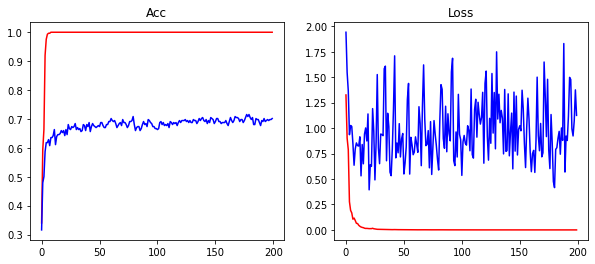

In [71]:
eva_train = model.evaluate(dataloader=trainloader)
print(f"Train Accuracy: {eva_train[1]:.4f}\tTrain Loss: {eva_train[0]:.4f}")
eva_test = model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

pred = model.predict(dataloader=testloader)

In [64]:
print(pred)
print(y_test)

[1. 3. 2. 1. 2. 1. 3. 3. 1. 3. 2. 0. 3. 2. 1. 2. 0. 3. 0. 3. 3. 0. 2. 1.
 0. 3. 1. 0. 0. 1. 1. 1. 3. 2. 0. 1. 0. 2. 1. 3. 1. 0. 2. 1. 2. 0. 0. 1.
 3. 0. 2. 2. 2. 2. 3. 3. 2. 2. 2. 0. 3. 0. 0. 3. 1. 1. 1. 0. 2. 0. 0. 3.
 3. 0. 3. 0. 2. 3. 3. 0. 3. 1. 0. 3. 3. 0. 3. 2. 0. 3. 1. 0. 3. 0. 2. 2.
 0. 3. 1. 2. 0. 1. 1. 1. 2. 0. 3. 0. 1. 0. 1. 3. 2. 2. 0. 2. 1. 3. 1. 1.
 3. 0. 0. 3. 1. 2. 0. 1. 3. 3. 1. 3. 3. 0. 3. 3. 3. 3. 3. 1. 2. 1. 0. 3.
 0. 1. 0. 0. 2. 3. 2. 2. 3. 0. 3. 2. 3. 2. 0. 2. 2. 3. 0. 0. 3. 1. 3. 3.
 3. 2. 1. 2. 3. 0. 3. 3. 0. 1. 0. 0. 2. 0. 1. 2. 0. 3. 0. 1. 0. 1. 3. 2.
 1. 1. 3. 3. 2. 0. 1. 2. 0. 3. 2. 0. 0. 2. 2. 0. 1. 0. 3. 1. 0. 0. 3. 3.
 0. 3. 1. 3. 0. 0. 0. 1. 2. 0. 2. 3. 1. 3. 3. 1. 3. 2. 1. 2. 1. 2. 1. 0.
 3. 2. 3. 3. 3. 1. 1. 0. 2. 0. 0. 2. 2. 1. 3. 0. 0. 0. 1. 3. 2. 3. 3. 0.
 3. 0. 3. 3. 0. 3. 1. 2. 0. 0. 3. 1. 0. 3. 2. 3. 2. 0. 0. 1. 0. 2. 0. 3.]
tensor([0, 1, 1, 0, 1, 0, 1, 2, 1, 3, 0, 2, 1, 0, 3, 3, 3, 3, 3, 0, 2, 1, 0, 0,
        2, 3, 0, 2, 2, 2, 0, 1, 0, 1, 1, 0,

ref

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SCCNet().to(device)
summary(model, (1, 22, 562))
cmp = Tensor().numpy() == np.array()
cmp.all()